<a href="https://colab.research.google.com/github/Maria223-del/Project/blob/main/%D0%9F%D1%80%D0%BE%D0%B5%D0%BA%D1%82_(%D0%94%D0%B0%D0%BC%D0%B8%D1%80%D0%BE%D0%B2%D0%B0).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping


# Загрузка данных
train_df = pd.read_csv('/content/mitbih_train.csv', header=None)
test_df = pd.read_csv('/content/mitbih_test.csv', header=None)


print("Форма тренировочных данных:", train_df.shape)
print("Форма тестовых данных:", test_df.shape)

Форма тренировочных данных: (87554, 188)
Форма тестовых данных: (21892, 188)


Распределение классов в тренировочной выборке:
Класс 0.0: 72471 samples (82.77%)
Класс 1.0: 2223 samples (2.54%)
Класс 2.0: 5788 samples (6.61%)
Класс 3.0: 641 samples (0.73%)
Класс 4.0: 6431 samples (7.35%)


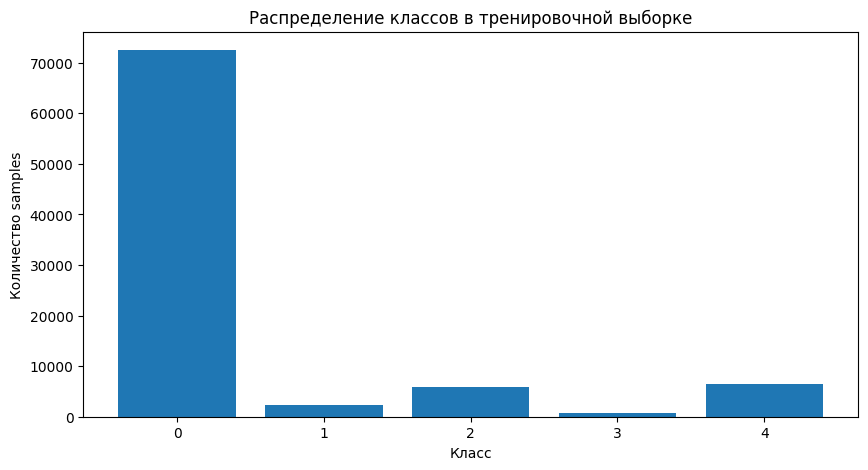

In [2]:
# Последний столбец - это метка класса
X_train = train_df.iloc[:, :-1].values  # Все столбцы кроме последнего
y_train = train_df.iloc[:, -1].values   # Только последний столбец


X_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].values


# распределение классов
print("Распределение классов в тренировочной выборке:")
unique, counts = np.unique(y_train, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Класс {cls}: {count} samples ({count/len(y_train)*100:.2f}%)")


# визуализация распределения
plt.figure(figsize=(10, 5))
plt.bar(unique, counts)
plt.title('Распределение классов в тренировочной выборке')
plt.xlabel('Класс')
plt.ylabel('Количество samples')
plt.show()

In [3]:
# 1. Нормализация данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# 2. Преобразование в 3D-формат
# LSTM/CNNнужны данные в формате [samples, timesteps, features]
X_train_3d = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_3d = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)


# 3. One-hot кодирование меток
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)


print("Форма данных после подготовки:")
print(f"X_train: {X_train_3d.shape}")
print(f"y_train: {y_train_categorical.shape}")

Форма данных после подготовки:
X_train: (87554, 187, 1)
y_train: (87554, 5)


In [4]:
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        # Первый свёрточный блок
        Conv1D(64, kernel_size=5, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        # Второй свёрточный блок
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        # Третий свёрточный блок
        Conv1D(256, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        # Полносвязные слои
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model


# Создаем модель
input_shape = (X_train_3d.shape[1], 1)  # (187, 1)
num_classes = y_train_categorical.shape[1]  # 5 классов


cnn_model = create_cnn_model(input_shape, num_classes)
cnn_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 183, 64)        │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 91, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 91, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 89, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 44, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 44, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 42, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 21, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 21, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5376)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       688,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 812,549 (3.10 MB)

 Trainable params: 812,549 (3.10 MB)

 Non-trainable params: 0 (0.00 B)

Обучение CNN модели...
Epoch 1/50
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 155s 56ms/step - accuracy: 0.9140 - loss: 0.3128 - val_accuracy: 0.9648 - val_loss: 0.1286
Epoch 2/50
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 146s 53ms/step - accuracy: 0.9632 - loss: 0.1372 - val_accuracy: 0.9739 - val_loss: 0.0926
Epoch 3/50
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 144s 53ms/step - accuracy: 0.9689 - loss: 0.1139 - val_accuracy: 0.9770 - val_loss: 0.0819
Epoch 4/50
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 204s 53ms/step - accuracy: 0.9708 - loss: 0.1066 - val_accuracy: 0.9777 - val_loss: 0.0791
Epoch 5/50
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 202s 53ms/step - accuracy: 0.9718 - loss: 0.0983 - val_accuracy: 0.9778 - val_loss: 0.0818
Epoch 6/50
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 201s 53ms/step - accuracy: 0.9725 - loss: 0.0946 - val_accuracy: 0.9804 - val_loss: 0.0710
Epoch 7/50
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 203s 54ms/step - accuracy: 0.9765 - loss: 0.0857 - val_accuracy: 0.9790 - val_loss: 0.0761
Epoch 8/50
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 147s

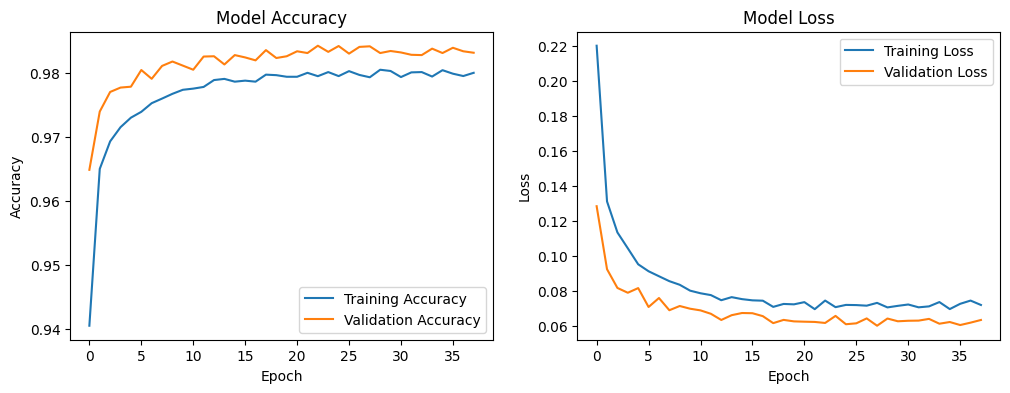

685/685 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step

Отчет по классификации:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     18118
         1.0       0.95      0.71      0.81       556
         2.0       0.96      0.96      0.96      1448
         3.0       0.94      0.66      0.78       162
         4.0       0.99      0.98      0.99      1608

    accuracy                           0.98     21892
   macro avg       0.96      0.86      0.91     21892
weighted avg       0.98      0.98      0.98     21892



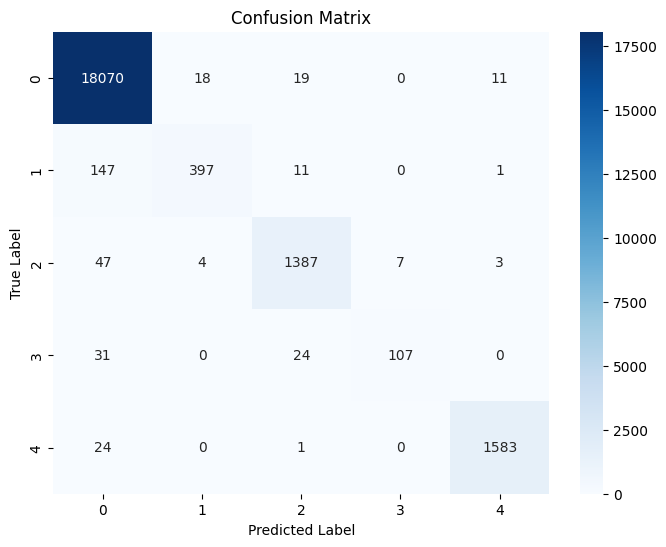

In [5]:
# Callback для ранней остановки (чтобы не переобучаться)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


# Обучение CNN модели
print("Обучение CNN модели...")
history = cnn_model.fit(X_train_3d, y_train_categorical,
                       epochs=50,
                       batch_size=32,
                       validation_data=(X_test_3d, y_test_categorical),
                       callbacks=[early_stopping],
                       verbose=1)


# Оценка модели
test_loss, test_accuracy = cnn_model.evaluate(X_test_3d, y_test_categorical, verbose=0)
print(f"\nТочность на тестовой выборке: {test_accuracy:.4f}")


# Визуализация обучения
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Детальная оценка
y_pred = cnn_model.predict(X_test_3d)
y_pred_classes = np.argmax(y_pred, axis=1)


print("\nОтчет по классификации:")
print(classification_report(y_test, y_pred_classes))


# Матрица ошибок
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()